In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from Config import Config 


In [12]:
min_date = pd.to_datetime("2020-08-09")
max_date = pd.to_datetime("2021-04-01")

In [20]:
prisoners_f = "processed_data/viasna_data/viasna_political_prisoners.csv"
prisoners = pd.read_csv(prisoners_f)

# An incident means detention (including at the border), drawing up a report, search, etc.
incedents_f = "processed_data/viasna_data/persecutionDatabase.csv"
incedents = pd.read_csv(incedents_f)

In [22]:
# create date time 
prisoners.date_of_detention = pd.to_datetime(prisoners.date_of_detention)
incedents.date_of_incident = pd.to_datetime(incedents.date_of_incident)

# filter by date
prisoners_date_filt = (prisoners.date_of_detention >= min_date) & (prisoners.date_of_detention <= max_date)
prisoners_filt = prisoners.loc[prisoners_date_filt, :]

incedents_date_filt = (incedents.date_of_incident >= min_date) & (incedents.date_of_incident <= max_date)
incedents_filt = incedents.loc[incedents_date_filt, :]

In [23]:
# Daily number of prisoners
daily_num_prisoners = (
    prisoners_filt
    .groupby("date_of_detention")["name"]
    .count()
    .reset_index()
    .rename(columns={"date_of_detention": "date" ,"name": "num_prisoners"})
    )

# Daily number of incidents
daily_num_incedents = (
    incedents_filt
    .groupby("date_of_incident")["name"]
    .count()
    .reset_index()
    .rename(columns={"date_of_incident": "date","name": "num_incidents"})
    )

In [24]:
# add any missing days between min/max to the dataset
all_days = pd.date_range(min_date, max_date, freq='D')

# check for missing days and fill the num_detentions column with 0 
daily_num_prisoners = ( 
    daily_num_prisoners
    .set_index("date") 
     .reindex(all_days) # reindex using all_days - this adds any missing days to the dataset 
     .rename_axis(['date'])
     .fillna(0)
     .reset_index()
)

# check for missing days and fill the num_detentions column with 0 
daily_num_incedents = ( 
    daily_num_incedents
    .set_index("date") 
     .reindex(all_days) # reindex using all_days - this adds any missing days to the dataset 
     .rename_axis(['date'])
     .fillna(0)
     .reset_index()
)

In [25]:
# merge prisoners and incidents
df_merge = daily_num_prisoners.merge(daily_num_incedents, how="left", on="date")

In [26]:
# Day of week 
df_merge["day_of_week"] = df_merge.date.dt.day_name()

In [27]:
df_merge.head()

,date,num_prisoners,num_incidents,day_of_week
0,2020-08-09,5.0,3630.0,Sunday
1,2020-08-10,18.0,1799.0,Monday
2,2020-08-11,7.0,1093.0,Tuesday
3,2020-08-12,6.0,274.0,Wednesday
4,2020-08-13,3.0,48.0,Thursday


<AxesSubplot:>

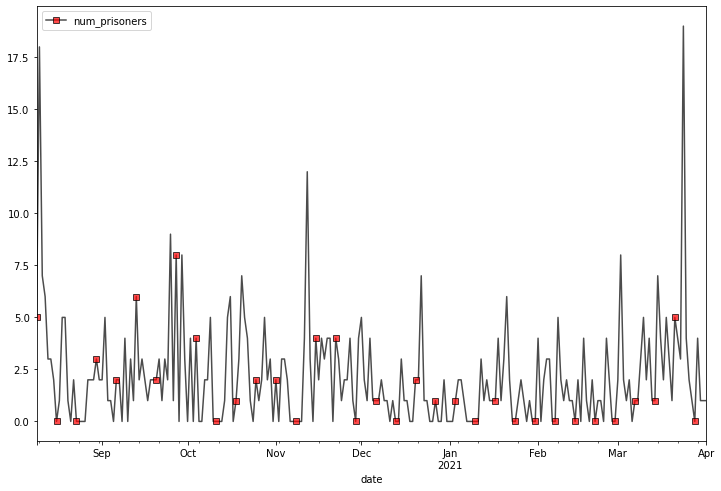

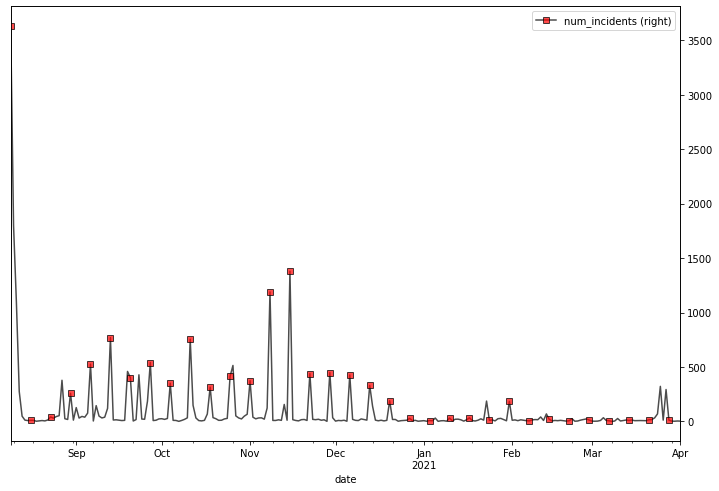

In [28]:
ax1 = df_merge.plot(
    x="date", 
    y="num_prisoners",
    figsize=(12,8)
    style='s-',
    color="black", 
    mfc = "red",  
    alpha=0.7,  
    markevery = np.where(df_merge["day_of_week"] == "Sunday", True, False)
    )

df_merge.plot(
    x="date", 
    y="num_incidents",
    figsize=(12,8),
    style='s-', 
    color="black", 
    mfc = "red",   
    alpha=0.7, 
    secondary_y=True,
    markevery = np.where(df_merge["day_of_week"] == "Sunday", True, False),
    )



In [29]:
df_merge.sort_values(by="num_prisoners", ascending=False).head(5)

,date,num_prisoners,num_incidents,day_of_week
227,2021-03-24,19.0,69.0,Wednesday
1,2020-08-10,18.0,1799.0,Monday
95,2020-11-12,12.0,10.0,Thursday
47,2020-09-25,9.0,20.0,Friday
205,2021-03-02,8.0,2.0,Tuesday


In [32]:
# save data
f_name = "viasna_dailyCounts_Aug_March.csv"
path = os.path.join(Config.proccessed_data_dir, Config.viasna_data_subdir, f_name)
df_merge.to_csv(path, index=False)

In [ ]:
# https://apnews.com/article/belarus-alexander-lukashenko-minsk-archive-elections-038f05df4d1fa275e648acc624467171
# detention v/s arrests: https://www.thomasianlaw.com/blog/2022/september/what-s-the-difference-between-a-detention-and-an/
# Detainment may lead to arrest
